In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import pymc3 as pm
import theano
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
data = pd.read_excel("ActualDataFeb2020.xlsx")
data

,Дата - Время,Gpp,Tpp,Gp4,Go4,Tp4,T04,Gp5,Go5,Tp5,...,GpSN4,GoSN4,TpSN4,ToSn4,GpSN5,GoSN5,TpSN5,ToSN5,GoSN2,ToSN2
0,12.02.2020 - 00:00:00,309.94,107.65,1922,2042,109.35,63.53,1172,779,112.04,...,276.85,151.91,99.15,83.48,219.48,293.34,111.62,88,66.78,82
1,12.02.2020 - 00:10:00,315.52,107.42,1920,2042,109.47,63.55,1172,777,111.99,...,276.70,151.86,99.17,83.49,219.41,292.78,111.64,88,47.67,82
2,12.02.2020 - 00:20:00,308.43,107.32,1922,2044,109.50,63.59,1181,788,112.02,...,276.35,151.41,99.22,83.50,219.10,290.53,111.59,88,38.99,82
3,12.02.2020 - 00:30:00,320.57,107.29,1912,2039,109.39,63.61,1174,775,111.87,...,276.49,152.67,98.99,83.15,220.24,290.94,111.57,88,39.03,82
4,12.02.2020 - 00:40:00,320.70,107.32,1915,2043,109.37,63.62,1173,762,112.00,...,276.69,152.60,98.91,83.29,220.06,292.38,111.54,88,47.67,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,17.02.2020 - 20:30:00,328.01,104.36,1920,2020,94.41,58.83,1170,762,94.28,...,280.03,154.10,94.74,80.34,224.20,298.74,94.22,80,47.74,80
844,17.02.2020 - 20:40:00,328.26,104.45,1913,2015,94.38,58.80,1168,754,94.54,...,280.05,154.34,94.53,80.31,224.18,298.11,94.51,80,72.36,80
845,17.02.2020 - 20:50:00,334.60,104.47,1921,2020,94.20,58.81,1176,750,94.75,...,280.28,154.27,94.46,80.31,223.85,298.43,94.66,80,103.34,79
846,17.02.2020 - 21:00:00,329.48,105.08,1919,2013,94.14,58.83,1179,748,95.63,...,280.07,154.34,94.27,80.26,224.26,296.79,95.05,80,89.63,79


In [11]:
obs_Go2=data['Go2']
shape_Go2=2

w_Go2=pm.floatX([0.7,0.3])
mu_Go2=[810,890]
sd_Go2=obs_Go2.std()
print(mu_Go2,sd_Go2)

obs_GoSN2=data['GoSN2']
shape_GoSN2=2


mu_GoSN2=65
sd_GoSN2=1
print(mu_GoSN2,sd_GoSN2)


with pm.Model() as model:
    obs_w_Go2=pm.Normal('obs_w_Go2',mu=w_Go2.mean(),sd=w_Go2.std(),shape=shape_Go2)
    obs_mu_Go2=pm.Normal("obs_mu_Go2",mu=mu_Go2,sd=sd_Go2,shape=shape_Go2)
    obs_sd_Go2=pm.Exponential("obs_sd_Go2",lam=5,shape=shape_Go2)
   
    
    #матожидание дисперсии тоже приходится указывать близким к истине, иначе не сошлось у меня 
    apost_Go2=pm.NormalMixture("apost_Go2",w=obs_w_Go2, 
                               mu=obs_mu_Go2,sigma=obs_sd_Go2,observed=obs_Go2)
    apost_GoSN2=pm.Normal("apost_GoSN2", 
                                 mu=mu_GoSN2,sigma=sd_GoSN2,observed=obs_GoSN2)
    
    apost_Gp2=pm.Deterministic('apost_Gp2',apost_Go2+apost_GoSN2)
    
    

[810, 890] 41.97849717683337
65 1


In [12]:
with model:
    start=pm.find_MAP()
    print(start)
    step=pm.NUTS()
    trace=pm.sample(3000,step=step,tune=500,chains=1) 

logp = -inf, ||grad|| = 1.9937: 100%|██████████| 14/14 [00:00<00:00, 2213.85it/s]  


{'obs_w_Go2': array([0.49993305, 0.49990968]), 'obs_mu_Go2': array([810.01026225, 890.00364497]), 'obs_sd_Go2_log__': array([-1.62753988, -1.24403525]), 'obs_sd_Go2': array([0.19641218, 0.28821883]), 'apost_Gp2': array([ 913.26,  879.05,  881.66,  881.06,  900.4 ,  864.92,  884.05,
        903.28,  927.34,  902.18,  914.78,  948.3 ,  872.46,  889.88,
        901.87,  929.15,  877.77,  847.4 ,  916.69,  936.15,  925.07,
        878.76,  886.55,  891.17,  892.39,  947.94,  963.26,  868.13,
        898.6 ,  837.73,  868.19,  843.8 ,  888.76,  884.52,  932.75,
        873.27,  930.79,  856.02,  920.43,  888.51,  888.55,  911.53,
        913.03,  944.66,  919.18,  895.46,  848.68,  931.07,  870.64,
        861.37,  839.64,  911.53,  846.04,  876.06,  936.44,  885.68,
        845.82,  888.8 ,  838.53,  834.13,  909.98,  879.31,  859.95,
        866.1 ,  885.24,  862.31,  894.91,  810.49,  874.44,  848.04,
        905.16,  877.14,  916.09,  826.99,  883.86,  880.96,  825.72,
        860.32,  

Sequential sampling (1 chains in 1 job)
NUTS: [obs_sd_Go2, obs_mu_Go2, obs_w_Go2]
Sampling chain 0, 2,628 divergences: 100%|██████████| 3500/3500 [00:57<00:00, 60.78it/s]
There were 2629 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9197031246776363, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


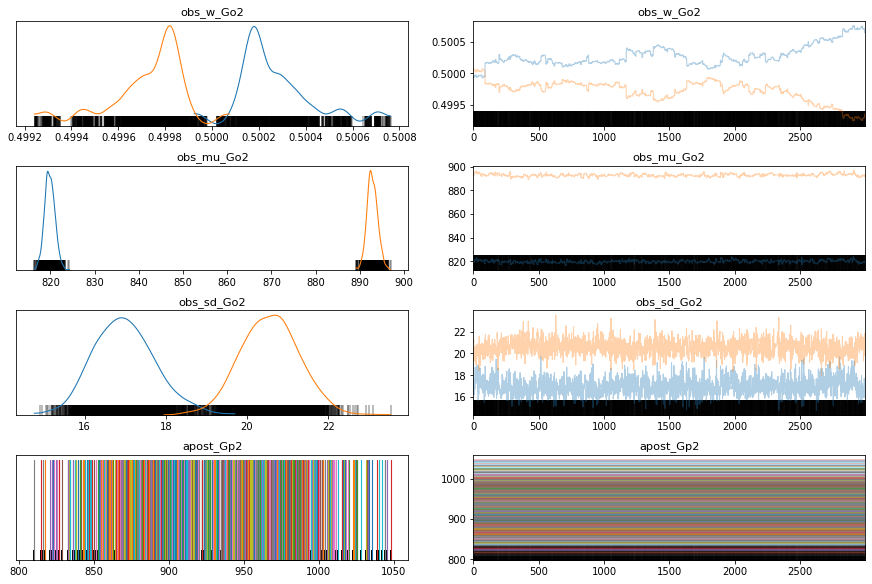

In [13]:
pm.traceplot(trace);

/home/danil/.local/lib/python3.6/site-packages/arviz/plots/plot_utils.py:653: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (854) in plot_posterior, generating only 40 plots
  UserWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fe6081b38>,
      dtype=object)

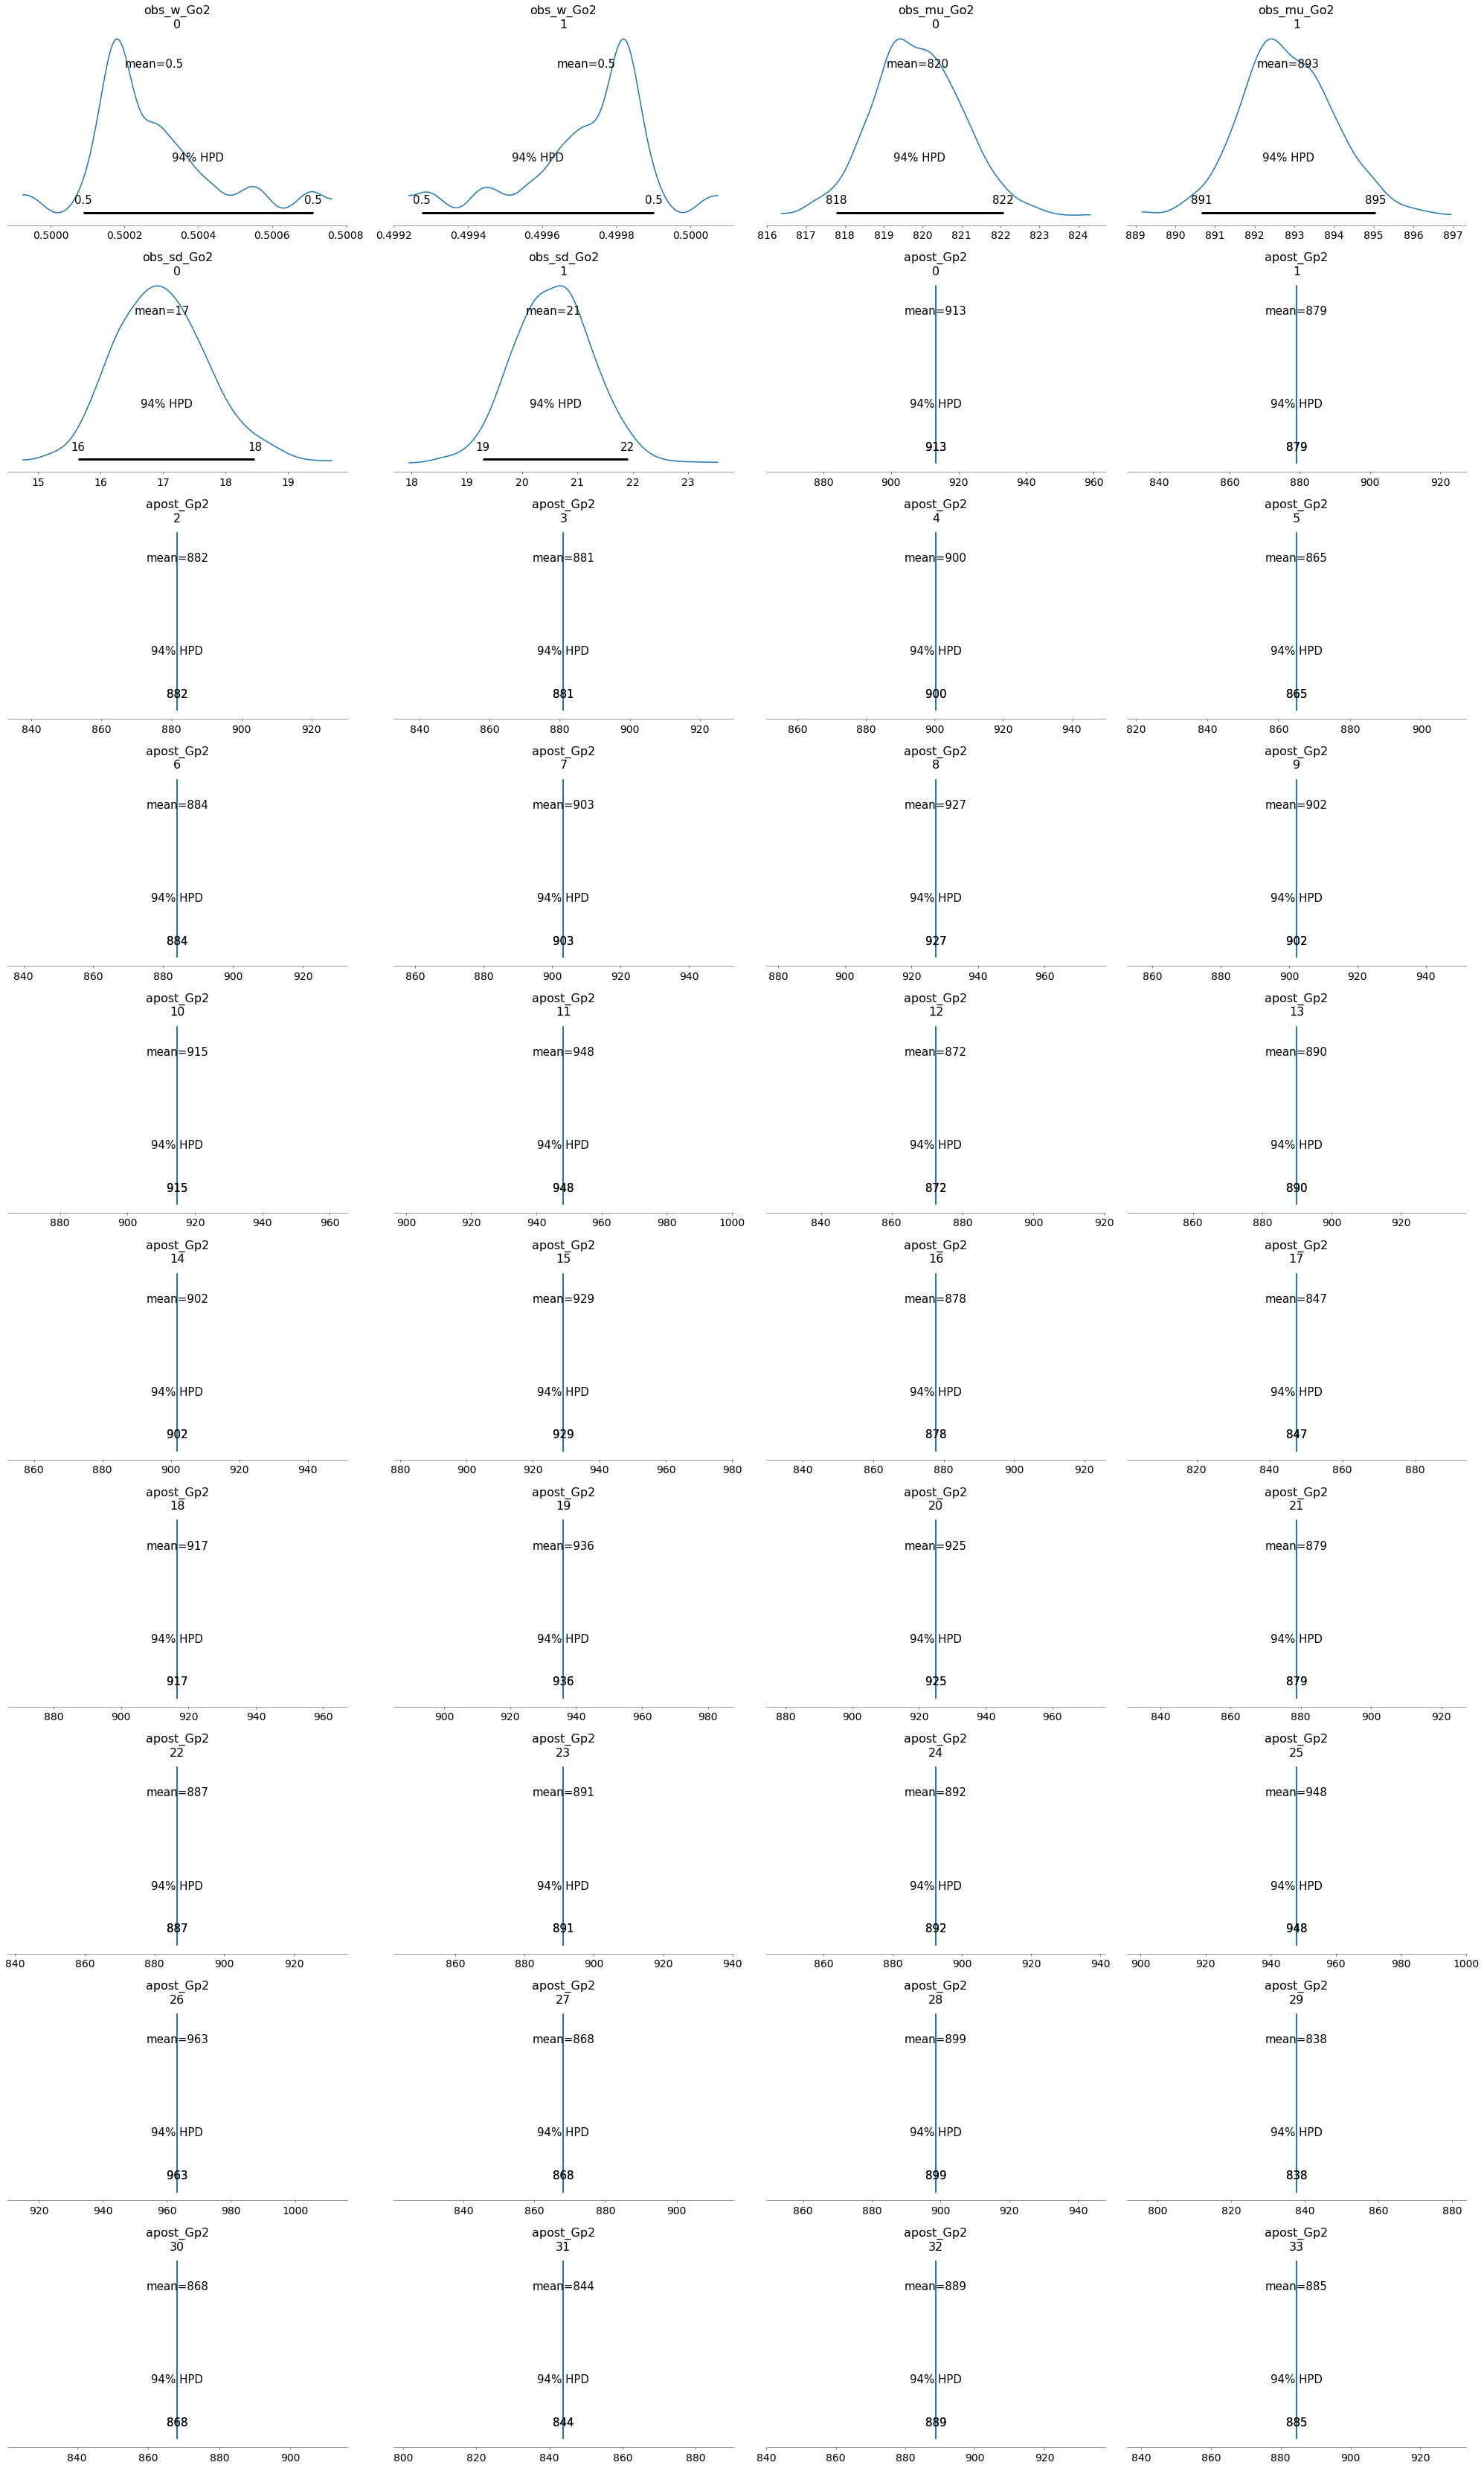

In [14]:
pm.plots.plot_posterior(trace)

In [15]:
#так можно доставать параметры 
data_trace=pm.trace_to_dataframe(trace) # значения элементов цепочек в MCMC
data_trace

,obs_w_Go2__0,obs_w_Go2__1,obs_mu_Go2__0,obs_mu_Go2__1,obs_sd_Go2__0,obs_sd_Go2__1,apost_Gp2__0,apost_Gp2__1,apost_Gp2__2,apost_Gp2__3,...,apost_Gp2__838,apost_Gp2__839,apost_Gp2__840,apost_Gp2__841,apost_Gp2__842,apost_Gp2__843,apost_Gp2__844,apost_Gp2__845,apost_Gp2__846,apost_Gp2__847
0,0.499946,0.500060,822.242521,893.851776,18.944812,20.228935,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35
1,0.499943,0.500058,821.911126,893.518514,16.607024,21.157973,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35
2,0.499944,0.500062,821.906662,893.508281,16.407353,21.019336,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35
3,0.499925,0.500070,821.552331,892.481437,16.195299,21.229446,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35
4,0.499928,0.500071,821.331960,892.389715,16.286986,19.409470,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.500646,0.499352,819.364959,891.740790,16.685991,21.857453,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35
2996,0.500658,0.499347,818.973889,891.841905,16.911001,21.371107,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35
2997,0.500659,0.499346,819.086244,891.895150,16.249193,20.379309,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35
2998,0.500656,0.499342,818.984180,892.036435,16.004355,20.828793,913.26,879.05,881.66,881.06,...,1031.42,961.94,1015.75,971.8,961.04,950.61,950.55,979.4,1010.22,990.35


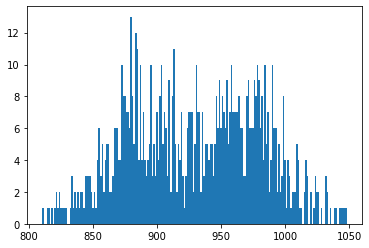

In [16]:
plt.hist(data_trace.iloc[2999,13:],bins=200)
plt.show()

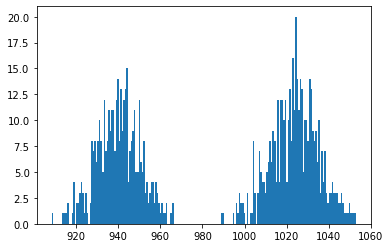

In [17]:
plt.hist(data['Gp2'],bins=200)
plt.show()